<a href="https://colab.research.google.com/github/mateopolancecofficial/DeepLearningProjects/blob/main/Regression/VineyardExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [300]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from itertools import combinations

In [301]:
columns = ['x0', 'x1', 'x2', 'x3', 'u']
feature_ranges = {"x0": [1, 17], "x1": [-9, -4], "x2": [0, 3], "x3": [0, 50]}
source_path = "./Data/podaci.csv"
train_size, test_size, val_size = 0.8, 0.2, 0.2

In [302]:
df = pd.read_csv(source_path, names=columns)
df.head()

,x0,x1,x2,x3,u
0,9.353670,-5.681740,1.739091,26.117712,95.610349
1,7.136365,-8.842209,1.712237,42.389300,171.811854
2,11.457191,-8.771499,1.500788,41.984114,173.865403
3,8.772591,-4.087157,2.443511,12.612862,53.146681
4,4.958833,-8.140877,1.651389,34.904362,142.692822


In [303]:
df.describe()

,x0,x1,x2,x3,u
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,8.791439,-6.613959,1.528241,26.049980,108.149899
std,4.653434,1.412722,0.858456,13.886081,34.839117
min,1.253278,-8.994504,0.053720,0.049785,22.550903
25%,4.679236,-7.922337,0.758000,15.002370,81.192576
50%,8.724418,-6.601377,1.552406,26.236388,110.872981
75%,12.766403,-5.485084,2.291555,36.993059,136.567023
max,16.991696,-4.006333,2.989752,49.719666,185.125604


Sensor data are not out of range for all features.

In [304]:
df.dtypes

x0    float64
x1    float64
x2    float64
x3    float64
u     float64
dtype: object

In [305]:
df_missing = df.isnull().sum()
df_missing

x0    0
x1    0
x2    0
x3    0
u     0
dtype: int64

In [306]:
def miss_percentage(df):
    """
    Calculate missing value percentage per dataset features (columns in dataframe).
    :param df: input pandas dataframe with missing values
    :return:   pandas dataframe, index = column names, columns = [missing values percentage, missing count]
    """
    df_missing = df.isnull().sum().reset_index()
    df_missing.columns = ['features', 'missing_counts']
    df_len = df.shape[0]
    df_missing['missing_percentage'] = df_missing['missing_counts'].apply(lambda v: v/df_len)

    return df_missing.sort_values(by='missing_percentage', ascending=False).set_index(keys='features')

In [307]:
df_miss_info = miss_percentage(df)
df_miss_info

,missing_counts,missing_percentage
features,,
x0,0,0.0
x1,0,0.0
x2,0,0.0
x3,0,0.0
u,0,0.0


All features are numeric (float) and there is no missing values.

### Calculate feature correlations

In [308]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [309]:
def plot_feature_distributions():
  """
  Plot histograms of all featues.
  """

  fig, ax = plt.subplots(2, 2)
  sns.distplot(df['x0'], hist=True, kde=False, label='All values', bins=40,
             ax=ax[0, 0])
  sns.distplot(df['x1'], hist=True, kde=False, label='All values', bins=40,
             ax=ax[0, 1])
  sns.distplot(df['x2'], hist=True, kde=False, label='All values', bins=40,
             ax=ax[1, 0])
  sns.distplot(df['x3'], hist=True, kde=False, label='All values', bins=40,
             ax=ax[1, 1])

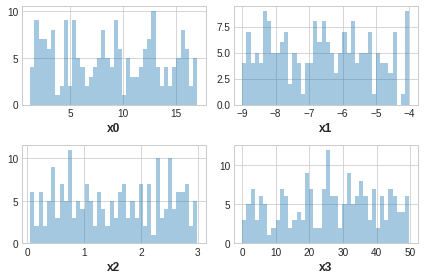

In [310]:
plot_feature_distributions()

All features need to be normalized with sifting distribution to become more like bell shape curve.

In [311]:
def plot_target_distribution():
  """
  Plot histograms of target variable.
  """

  sns.distplot(df['u'], hist=True, kde=False, label='All values', bins=40)

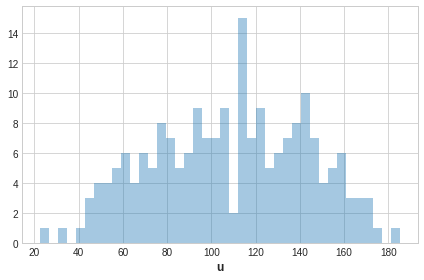

In [312]:
plot_target_distribution()

Target variable can be just standardized because distribution is approximately bell shape curve.

### Correlations between features and target variable

In [313]:
import scipy as sc

def get_correlation_coefficients(features_combinations: list):
  """
  Calculate Pearson and Spearman correlation coefficients between features
  and target variable.
  :param features_combinations: list of combinations of input features and target names, list of tuples
  :return result_coefficients: dict, key - name of related features, value - pandas dataframe
  """

  result_coefficients = {}

  for features in features_combinations:
    
      stats_pe_spe = {"corr": [], "p-value": []}

      pearson_price_points = sc.stats.pearsonr(df[features[0]], df[features[1]])
      spearman_price_points = sc.stats.spearmanr(df[features[0]], df[features[1]])

      for i in range(len(list(stats_pe_spe.keys()))):
        stats_pe_spe[list(stats_pe_spe.keys())[i]].append(pearson_price_points[i])
        stats_pe_spe[list(stats_pe_spe.keys())[i]].append(spearman_price_points[i])

      result_coefficients[features[0] + "-" + features[1]] = pd.DataFrame(stats_pe_spe, columns=['corr', 'p-value'], index=['pearson', 'spearman'])  
  
  return result_coefficients

In [314]:
#target = [columns.pop(-1)]
#features = columns
r = 2
features_target = list(set(list(combinations(columns, r))))
result_coefficients = get_correlation_coefficients(features_target)


In [315]:
for feature in list(result_coefficients.keys()):
  print(feature)
  print("----------------------------")
  print(result_coefficients[feature])
  print("\n")

x0-x3
----------------------------
              corr   p-value
pearson   0.080445  0.257477
spearman  0.095497  0.178580


x3-u
----------------------------
              corr       p-value
pearson   0.828818  7.960407e-52
spearman  0.833077  8.228812e-53


x0-u
----------------------------
              corr   p-value
pearson   0.234544  0.000829
spearman  0.231390  0.000978


x2-x3
----------------------------
              corr   p-value
pearson  -0.034601  0.626679
spearman -0.024545  0.730097


x1-x2
----------------------------
              corr   p-value
pearson   0.006414  0.928178
spearman  0.005717  0.935967


x0-x1
----------------------------
              corr   p-value
pearson  -0.071891  0.311718
spearman -0.076520  0.281502


x1-u
----------------------------
              corr       p-value
pearson  -0.573213  7.299622e-19
spearman -0.563587  3.677339e-18


x1-x3
----------------------------
              corr   p-value
pearson  -0.040232  0.571643
spearman -0.043659

In [316]:
def plot_feature_correlations(df):
  """
  Draw scatter plots of all features.
  :param df: input pandas dataframe
  """
  sns.pairplot(df)


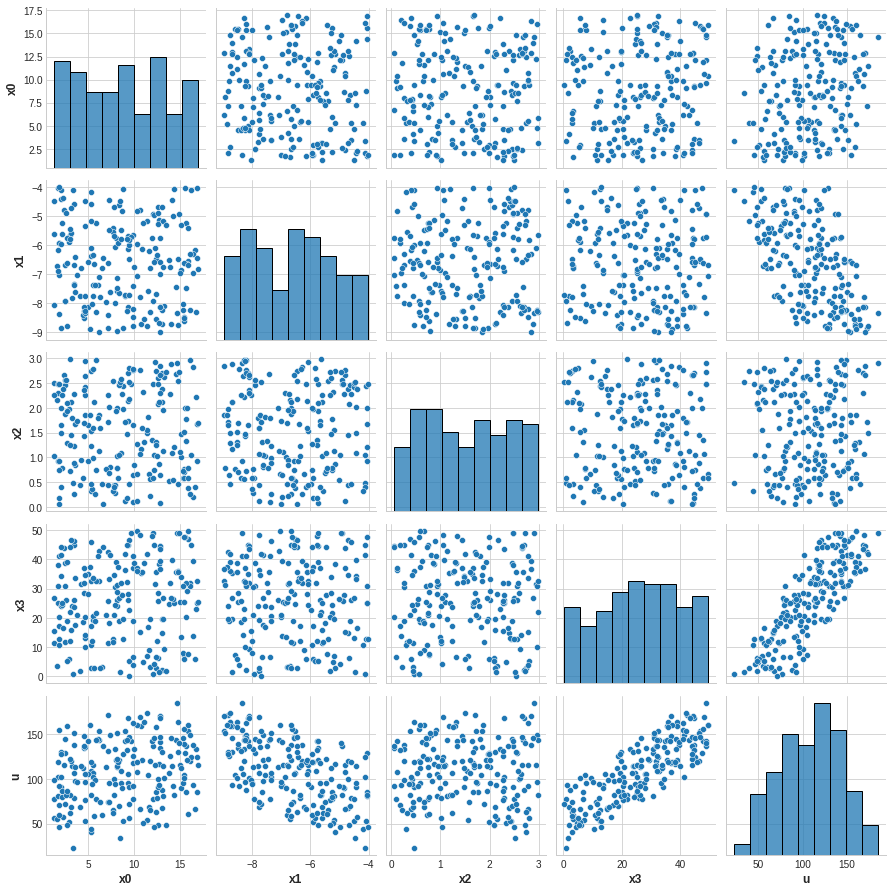

In [317]:
plot_feature_correlations(df)

x1 and x3 are features of high relevance, also we can conclude that x2 feature is unrelevant and will add noise to our model.
All input features are independent between each other.

### Prepare dataset

In [318]:
def split_data(df: pd.DataFrame, features: list, target: list, train_size: float, 
               test_size: float, val_size: float):
  """
  Split dataset on train, test and validation subsets.
  :param df:          input pandas DataFrame
  :param features:    list of input features names
  :param target:      list of target column names
  :param train_size:  fraction of train size
  :param test_size:   fraction of test size
  :param val_size:    fraction of validation size
  :return:            dictionary, keys=names of DataFrame, columns=DataFrame
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  x_train, x_test, y_train, y_test = train_test_split(df[features], df[target],
                                     test_size=test_size, train_size=train_size)
    
  # split train set on train and validation subsets
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                      test_size=val_size, train_size=train_size)
  
  dataset_dict = {
      'x_train': x_train,
      'y_train': y_train,
      'x_val': x_val,
      'y_val': y_val,
      'x_test': x_test,
      'y_test': y_test
  }

  return dataset_dict

In [319]:
#target = [columns.pop(-1)]
#features = columns
dataset = split_data(df, features, target, train_size, test_size, val_size)

In [320]:
print("Train dataset shape: {}".format(dataset['x_train'].shape))
print("Validation dataset shape: {}".format(dataset['x_val'].shape))
print("Test dataset shape: {}".format(dataset['x_test'].shape))

Train dataset shape: (128, 4)
Validation dataset shape: (32, 4)
Test dataset shape: (40, 4)


In [321]:
def cause_relevant_features(df: pd.DataFrame, features: list, f_ranges: list):
  """
  Cause new data on relevant features (x1, x3) based on calculated statistics.
  :param df:          input pandas DataFrame
  :param f_ranges:    list of input features names
  :return new_df:     pandas DataFrame with new data
  """

  new_data = {}

  for idx in range(len(features)):

    std = df[features[idx]].std()
    mean = df[features[idx]].mean()

    data_range = [mean - (1.5 * std), mean + (1.5 * std)]

    new_data[features[idx]] = np.random.uniform(data_range[0], data_range[1], f_ranges[1]).reshape(f_ranges[1], 1).tolist()

  new_df = pd.DataFrame.from_dict(new_data)
  
  for fidx in range(len(features)):
    new_df[features[fidx]] = new_df[features[fidx]].map(lambda x: x[0])

  return new_df


In [322]:
f_ranges = [1, 100]
new_data = cause_relevant_features(dataset['x_train'], features, f_ranges)
new_data.describe()

,x0,x1,x2,x3
count,100.000000,100.000000,100.000000,100.000000
mean,8.842206,-6.566133,1.414884,25.829492
std,3.829991,1.219091,0.738687,12.589936
min,2.363026,-8.686180,0.244904,4.866684
25%,5.516071,-7.689251,0.739279,14.612057
50%,8.087261,-6.502516,1.381878,26.641800
75%,12.420369,-5.527612,2.119613,35.700039
max,15.312603,-4.551056,2.617641,46.749934


In [323]:
def get_target_values(df, target):
  """
  Return values of target variable based on input feature values.
  :param df:               pandas dataframe with input features
  :return target_result:   pandas dataframe with input features and target values
  """
  
  def calc_target_func(x0, x1, x2, x3):
    """
    Return target value.
    """

    return x0 + (x1**2) + x2 + (2*x3)
  

  df[target[0]] = df.apply(lambda row: calc_target_func(row['x0'], row['x1'], row['x2'], row['x3']), axis=1)

  return df

In [324]:
new_data = get_target_values(new_data, target)
new_data.describe()

,x0,x1,x2,x3,u
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,8.842206,-6.566133,1.414884,25.829492,106.501492
std,3.829991,1.219091,0.738687,12.589936,32.160128
min,2.363026,-8.686180,0.244904,4.866684,42.099980
25%,5.516071,-7.689251,0.739279,14.612057,85.990621
50%,8.087261,-6.502516,1.381878,26.641800,105.158199
75%,12.420369,-5.527612,2.119613,35.700039,130.834908
max,15.312603,-4.551056,2.617641,46.749934,180.272949


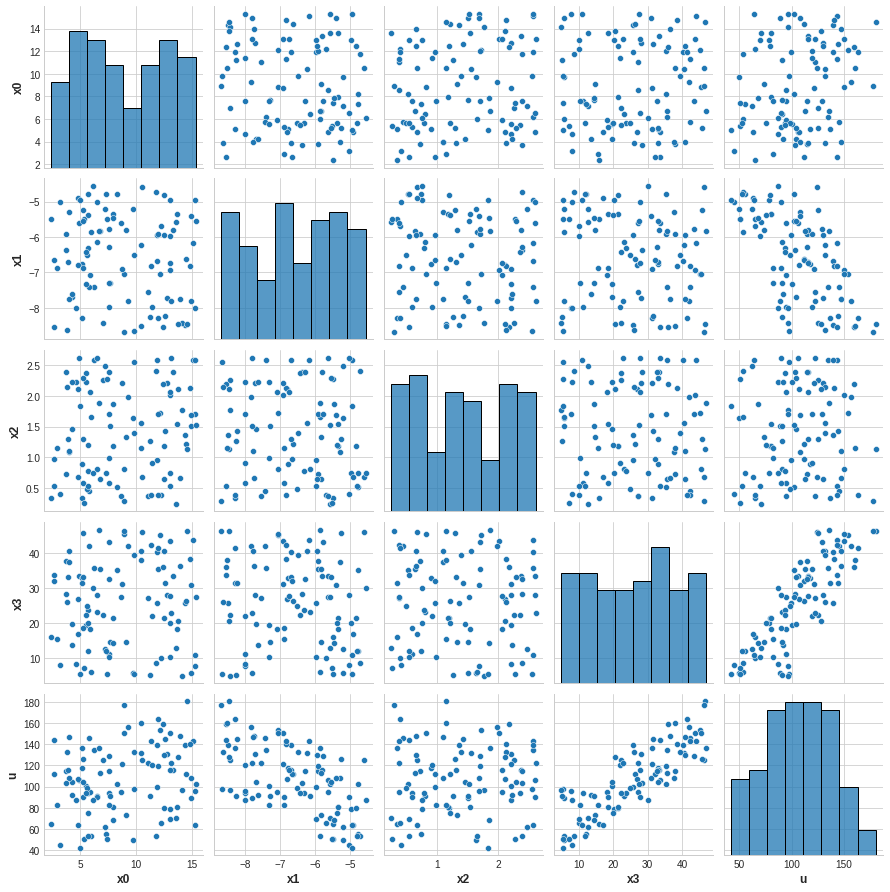

In [325]:
plot_feature_correlations(new_data)

In a new dataset features containes independent between each other while x1 and x3 features preserve relevance in relation to target variable.

In [326]:
def create_extra_train_dataset(df, df_new):
  """
  Extend train dataset with new data.
  :param df:               pandas dataframe with input features
  :param df_new:           pandas dataframe with input augmented features
  :return df_result:       pandas dataframe with input features and target values
  """

  return pd.concat([df, df_new], axis=0)

In [329]:
x_train = dataset['x_train'].reset_index()[features]
y_train = dataset['y_train'].reset_index()[target]


new_data = new_data.reset_index()[features + target]

train_data = pd.concat([x_train, y_train], axis=1)

df = create_extra_train_dataset(train_data, new_data)
train_data

,x0,x1,x2,x3,u
0,5.228111,-8.875780,1.858802,37.253023,160.372431
1,9.966983,-6.759035,0.847418,38.631777,133.762512
2,14.784221,-6.472594,2.537213,35.518199,130.252305
3,15.161025,-6.852914,1.003812,13.512713,90.152687
4,16.850152,-4.043301,1.666520,25.128945,85.122848
...,...,...,...,...,...
123,12.653967,-5.291797,2.604063,28.495350,100.251845
124,15.332189,-8.225659,0.720341,31.026136,145.766269
125,12.762731,-5.143926,0.865663,38.342566,116.773501
126,5.917513,-5.249729,0.743448,21.651485,77.523584


In [330]:
df

,x0,x1,x2,x3,u
0,5.228111,-8.875780,1.858802,37.253023,160.372431
1,9.966983,-6.759035,0.847418,38.631777,133.762512
2,14.784221,-6.472594,2.537213,35.518199,130.252305
3,15.161025,-6.852914,1.003812,13.512713,90.152687
4,16.850152,-4.043301,1.666520,25.128945,85.122848
...,...,...,...,...,...
95,14.920725,-5.403935,1.682410,30.930682,107.667018
96,13.759791,-8.450492,2.116616,20.506547,128.300315
97,7.892547,-5.463776,1.858871,14.357595,68.319455
98,10.475177,-8.513518,1.152348,38.011810,160.131130


### Normalize input datasets

### PCA - create new dataset

### Save datasets

In [339]:
 x_train = dataset['x_train'].reset_index()[features]
 x_train.to_csv('./Data/x_train.csv', index=False)

 y_train = dataset['y_train'].reset_index()[target]
 y_train.to_csv('./Data/y_train.csv', index=False)

In [340]:
probe = pd.read_csv('./Data/y_train.csv')
probe

,u
0,160.372431
1,133.762512
2,130.252305
3,90.152687
4,85.122848
...,...
123,100.251845
124,145.766269
125,116.773501
126,77.523584
